# Week 2 - Causal Inference Essentials

This is an introduction to the basics of estimating linear models for causal inference. The goal of this notebook is to try to estimate the effect of education on income, which has always been a key question in economic research

## Set up and load data

In [1]:
# Common imports
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib notebook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

# to make this notebook's output identical at every run
np.random.seed(42)

## State Level Data

We start from a dataset at the state level containing information from 1990. This data contains

- region of the country where the state is located 
- average SAT scores ($csat$)
- percentage of high school graduate taking SAT ($percent$)
- average per-pupile expenditure in primary and secondary education ($expanse$)
- median household income in thousands ($income$)
- percentage of adults with high school diploma ($high$)
- percentage of adults with college degree ($college$)

In [2]:
df = pd.read_stata('https://dss.princeton.edu/training/states.dta')
df_labels = pd.read_stata('https://dss.princeton.edu/training/states.dta', iterator=True).variable_labels()

Data Set Characteristics:

In [3]:
df.head()

,region,csat,percent,expense,income,high,college
0,South,991,8,3627,27.498,66.900002,15.700000
1,West,920,41,8330,48.254,86.599998,23.000000
2,West,932,26,4309,32.093,78.699997,20.299999
3,South,1005,6,3700,24.643,66.300003,13.300000
4,West,897,47,4491,41.716,76.199997,23.400000


In [4]:
df_labels

{'region': 'Geographical region',
 'csat': 'Mean composite SAT score',
 'percent': '% HS graduates taking SAT',
 'expense': 'Per pupil expenditures prim&sec',
 'income': 'Median household income, $1,000',
 'high': '% adults HS diploma',
 'college': '% adults college degree'}

In [5]:
df.describe()

,csat,percent,expense,income,high,college
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,944.098039,35.764706,5235.960784,33.956569,76.260803,20.021568
std,66.934970,26.192814,1401.155037,6.423134,5.588741,4.165780
min,832.000000,4.000000,2960.000000,23.465000,64.300003,12.300000
25%,888.000000,11.000000,4352.500000,29.875000,73.500000,17.300000
50%,926.000000,26.000000,5000.000000,33.452000,76.699997,19.299999
75%,997.000000,60.500000,5794.000000,36.919500,80.099998,22.900000
max,1093.000000,81.000000,9259.000000,48.618000,86.599998,33.299999


In [6]:
y = df['income']
x = df['college']

#### Explore your data

<AxesSubplot:xlabel='college', ylabel='income'>

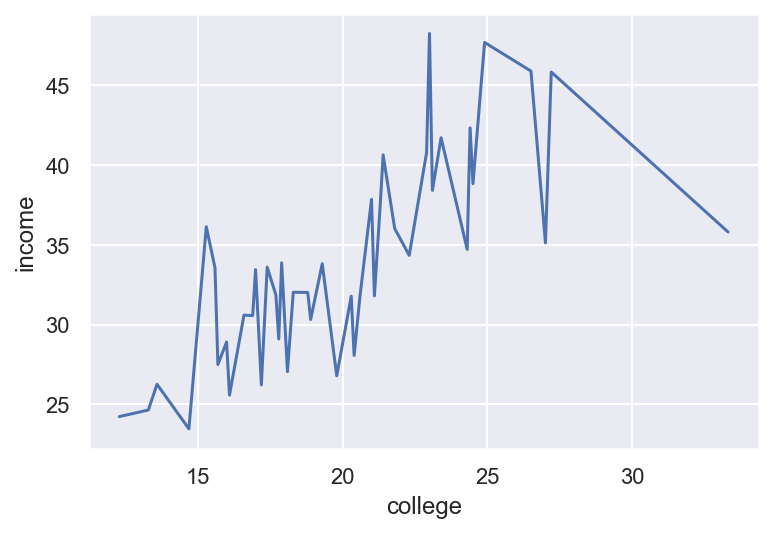

In [7]:
sns.lineplot(x, y, ci = None)

**What other relations can be helpful to explore before running the analysis?**

<AxesSubplot:xlabel='csat', ylabel='college'>

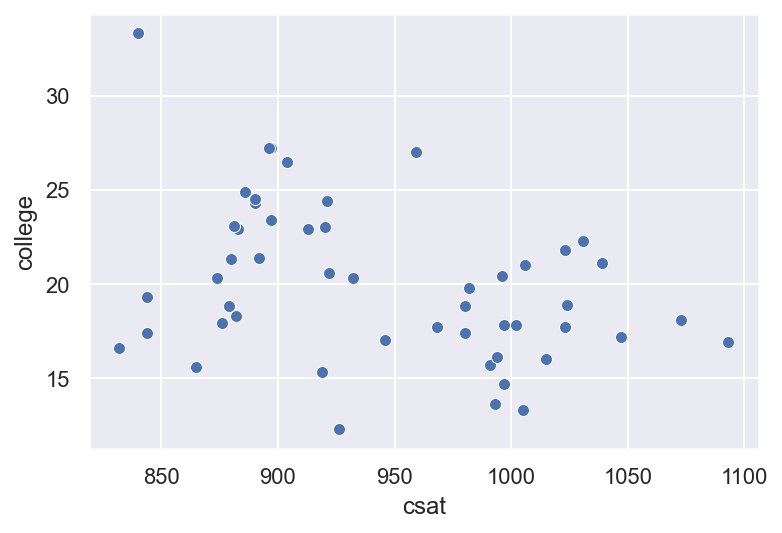

In [8]:
sns.scatterplot(x= 'csat', y='college', data=df, ci=None)

#### Running the first regression

To run simple regressions we will youse the package *statsmodels*. We start by running a simple regression of median income on the percentage of adults with a college degree:

<center>$income_i = \beta_0 + \beta_1 college_i + \varepsilon_i$</center>

In [9]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

res = smf.ols("income ~ college", data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     53.78
Date:                Fri, 07 Oct 2022   Prob (F-statistic):           2.02e-09
Time:                        15:35:28   Log-Likelihood:                -147.83
No. Observations:                  51   AIC:                             299.7
Df Residuals:                      49   BIC:                             303.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.6260      3.109      3.739      0.000       5.378      17.874
college        1.1153      0.152      7.333      0.000       0.810       1.421
==============================================================================
Omnibus:                        1.515   Durbin-Watson:                   2.271
Prob(Omnibus):                  0.469   Jarque-Bera (JB):                0.740
Skew:                           0.028   Prob(JB):                        0.691
Kurtosis:                       3.588   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Causal Interpretation:** The main coefficient of interest is the one on $college$. This result implies that, on average, an increase by 1 percentage point in college graduates increases median household income by \$1'115

<AxesSubplot:xlabel='college', ylabel='income'>

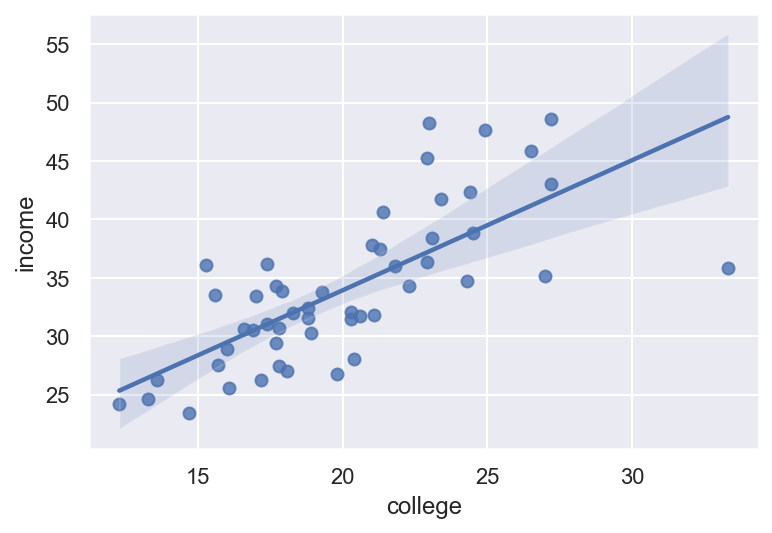

In [10]:
sns.regplot(x, y)

One potential source of bias could be the number of adults with a high school degree (why?). Luckly, we have the data on high school graduates and we can control for this in our regression.

In [12]:
res_con1 = smf.ols("income ~ college + high", data = df).fit()
res_con1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     28.76
Date:                Fri, 07 Oct 2022   Prob (F-statistic):           6.17e-09
Time:                        15:36:31   Log-Likelihood:                -146.63
No. Observations:                  51   AIC:                             299.3
Df Residuals:                      48   BIC:                             305.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8069      8.744     -0.092      0.927     -18.389      16.775
college        0.9722      0.177      5.485      0.000       0.616       1.329
high           0.2006      0.132      1.518      0.135      -0.065       0.466
==============================================================================
Omnibus:                        0.043   Durbin-Watson:                   2.308
Prob(Omnibus):                  0.979   Jarque-Bera (JB):                0.171
Skew:                           0.062   Prob(JB):                        0.918
Kurtosis:                       2.745   Cond. No.                     1.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**How did the coefficient on $college$ change? Did it change in the direction you expected?**

**Why could it not be a good idea to include the percentage of high school graduate in the regression? What other variables would you include?**

High percentage of parents with a college degree could affect the probability of kids having a high school degree.

In [13]:
res_con2 = smf.ols("income ~ college + C(region)", data=df).fit()
res_con2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     19.88
Date:                Fri, 07 Oct 2022   Prob (F-statistic):           1.75e-09
Time:                        15:36:45   Log-Likelihood:                -138.46
No. Observations:                  50   AIC:                             286.9
Df Residuals:                      45   BIC:                             296.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                7.6882      4.129      1.862      0.069      -0.627      16.004
C(region)[T.N. East]     1.9437      1.808      1.075      0.288      -1.698       5.586
C(region)[T.South]       0.0155      1.646      0.009      0.993      -3.299       3.330
C(region)[T.Midwest]     0.7454      1.707      0.437      0.665      -2.693       4.184
college                  1.3008      0.188      6.913      0.000       0.922       1.680
==============================================================================
Omnibus:                        2.703   Durbin-Watson:                   2.258
Prob(Omnibus):                  0.259   Jarque-Bera (JB):                1.900
Skew:                           0.460   Prob(JB):                        0.387
Kurtosis:                       3.253   Cond. No.                         152.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
print(summary_col([res,res_con1, res_con2]))


                     income I income II income III
--------------------------------------------------
C(region)[T.Midwest]                    0.7454    
                                        (1.7073)  
C(region)[T.N. East]                    1.9437    
                                        (1.8083)  
C(region)[T.South]                      0.0155    
                                        (1.6457)  
Intercept            11.6260  -0.8069   7.6882    
                     (3.1090) (8.7444)  (4.1286)  
R-squared            0.5232   0.5451    0.6386    
R-squared Adj.       0.5135   0.5261    0.6064    
college              1.1153   0.9722    1.3008    
                     (0.1521) (0.1773)  (0.1882)  
high                          0.2006              
                              (0.1321)            
Standard errors in parentheses.


**What are other problems that come up when using this regression to answer the initial research question?**

## Individual Level Data

In the second part we use data from the National Longitudinal Survey. In particular, we have a panel of young women who were between 14 and 26 years of age in 1988. We first have a look at our data and prepare them for the analysis. 

In [15]:
df = pd.read_stata('https://www.stata-press.com/data/r16/nlsw88.dta')
df_labels = pd.read_stata('https://www.stata-press.com/data/r16/nlsw88.dta', iterator=True).variable_labels()

In [16]:
df.head()

,idcode,age,race,married,never_married,grade,collgrad,south,smsa,c_city,industry,occupation,union,wage,hours,ttl_exp,tenure
0,1,37,black,single,0,12.0,not college grad,0,SMSA,0,Transport/Comm/Utility,Operatives,union,11.739125,48.0,10.333334,5.333333
1,2,37,black,single,0,12.0,not college grad,0,SMSA,1,Manufacturing,Craftsmen,union,6.400963,40.0,13.621795,5.250000
2,3,42,black,single,1,12.0,not college grad,0,SMSA,1,Manufacturing,Sales,NaN,5.016723,40.0,17.730770,1.250000
3,4,43,white,married,0,17.0,college grad,0,SMSA,0,Professional Services,Other,union,9.033813,42.0,13.211537,1.750000
4,6,42,white,married,0,12.0,not college grad,0,SMSA,0,Manufacturing,Operatives,nonunion,8.083731,48.0,17.820513,17.750000


In [17]:
df_labels

{'idcode': 'NLS id',
 'age': 'age in current year',
 'race': 'race',
 'married': 'married',
 'never_married': 'never married',
 'grade': 'current grade completed',
 'collgrad': 'college graduate',
 'south': 'lives in south',
 'smsa': 'lives in SMSA',
 'c_city': 'lives in central city',
 'industry': 'industry',
 'occupation': 'occupation',
 'union': 'union worker',
 'wage': 'hourly wage',
 'hours': 'usual hours worked',
 'ttl_exp': 'total work experience',
 'tenure': 'job tenure (years)'}

In [18]:
df.industry.value_counts()

Professional Services      824
Manufacturing              367
Wholesale/Retail Trade     333
Finance/Ins/Real Estate    192
Public Administration      176
Personal Services           97
Transport/Comm/Utility      90
Business/Repair Svc         86
Construction                29
Ag/Forestry/Fisheries       17
Entertainment/Rec Svc       17
Mining                       4
Name: industry, dtype: int64

In [19]:
df.occupation.value_counts()

Sales                     726
Professional/technical    317
Laborers                  286
Managers/admin            264
Operatives                246
Other                     187
Clerical/unskilled        102
Craftsmen                  53
Transport                  28
Service                    16
Farm laborers               9
Household workers           2
Farmers                     1
Name: occupation, dtype: int64

In [20]:
df.race.value_counts()

white    1637
black     583
other      26
Name: race, dtype: int64

In [21]:
##Drop missing observations
df_nomiss = df.dropna(subset=['collgrad', 'wage'])

#### Explore the data

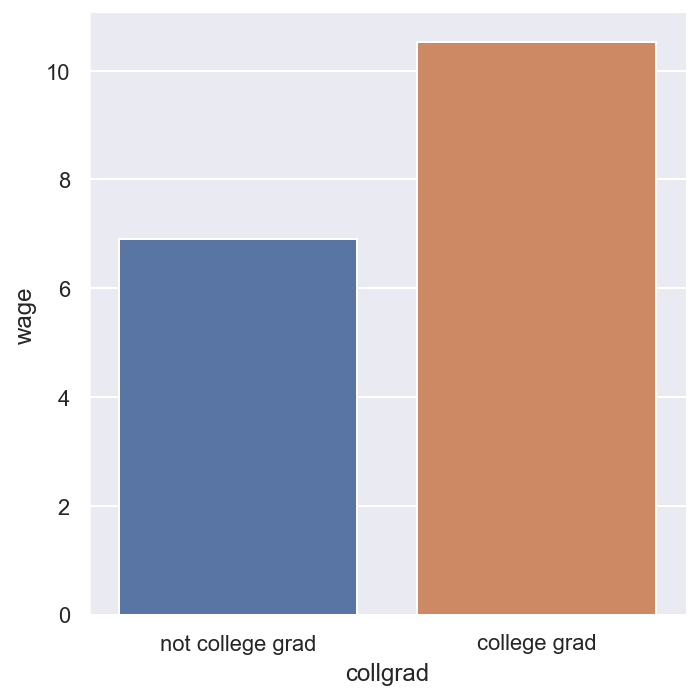

In [22]:
y = df_nomiss['wage']
x = df_nomiss['collgrad']
sns.catplot('collgrad', 'wage', kind = 'bar', data = df_nomiss, ci=None)

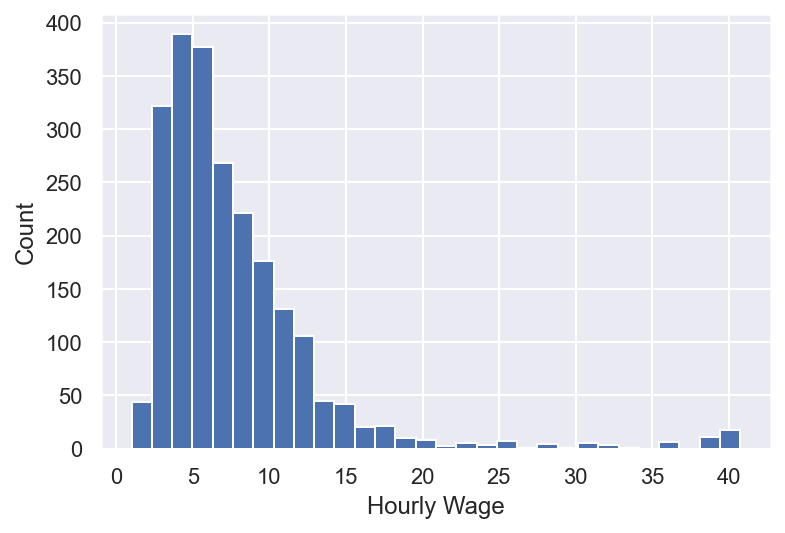

In [24]:
plt.hist(y, bins=30)
plt.xlabel("Hourly Wage", size=12)
plt.ylabel('Count', size=12)
plt.show()

#### Estimation

In [25]:
res = smf.ols("wage ~ C(collgrad)", data=df_nomiss).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     172.4
Date:                Fri, 07 Oct 2022   Prob (F-statistic):           5.26e-38
Time:                        16:52:02   Log-Likelihood:                -7034.2
No. Observations:                2246   AIC:                         1.407e+04
Df Residuals:                    2244   BIC:                         1.408e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       6.9106      0.134     51.572      0.000       6.648       7.173
C(collgrad)[T.college grad]     3.6155      0.275     13.132      0.000       3.076       4.155
==============================================================================
Omnibus:                     1612.161   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24903.685
Skew:                           3.295   Prob(JB):                         0.00
Kurtosis:                      17.923   Cond. No.                         2.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Causal Interpretation:** On average, having a college degree increases hourly wages by \$3.6

**What is the identification assumption behind this interpretation? Is it likely to be satisfied or not? Why?**

In [ ]:
res1 = smf.ols("wage ~ C(collgrad) + ...", data=df_nomiss).fit()
res2 = smf.ols("wage ~ C(collgrad) + ...", data=df_nomiss).fit()
res3 = smf.ols("wage ~ C(collgrad) + ...", data=df_nomiss).fit()

In [ ]:
print(summary_col([res,res1,res2,res3]))

### Residuals

So far we have assumed *homoskedastic* errors, meaning that we assumed the variance of the error term in our regression to be the same across observations and to be independent on the values of the explanatory variable. To investigate if this is the case, we need to calculate the residuals:

<center>$e_i = y_i - \hat{y}_i$</center>

where $\hat{y}_i$ are the predicted values of the wage. Once we have the residuals, one way to investigate if the errors are homoskedastic or not is to plot the fitted value of the dependent variable against the residuals form the regression.

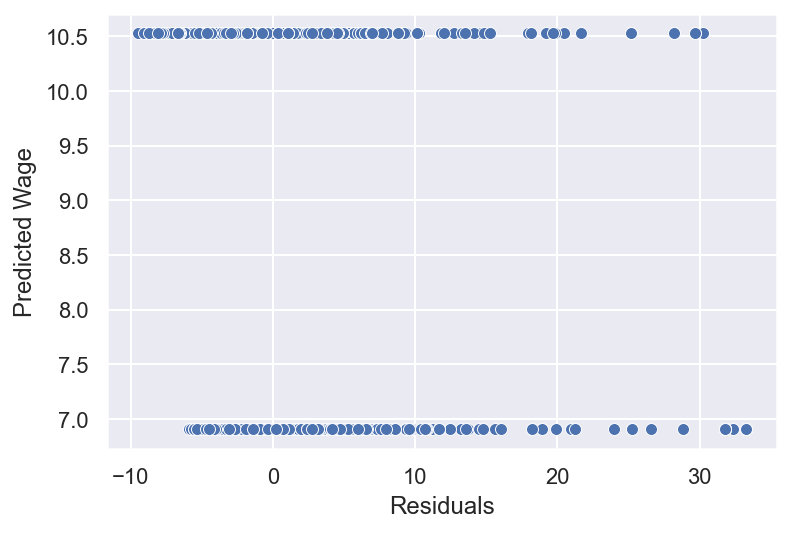

In [26]:
yhat = res.predict()
resid = y - yhat

resid_plot = sns.scatterplot(resid, yhat)
resid_plot.set(xlabel='Residuals', ylabel='Predicted Wage')
plt.show()

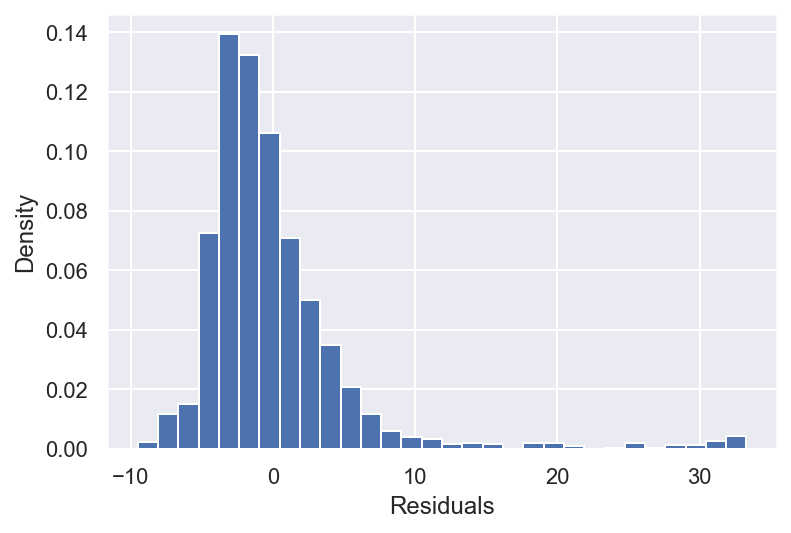

In [27]:
plt.hist(resid, bins=30, density=True)
plt.xlabel("Residuals", size=12)
plt.ylabel('Density', size=12)
plt.show()

The errors from our regression present evidence of mild heteroskedasticity. Therefore, to correctly estimate the causal effect of interest, we need to corrct for it by estimating the covariance matrix in a *robust* way. 

In [28]:
res_rob = smf.ols("wage ~ C(collgrad)", data=df_nomiss).fit(cov_type='HC1')
print(summary_col([res,res_rob]))


                             wage I  wage II 
---------------------------------------------
Intercept                   6.9106   6.9106  
                            (0.1340) (0.1276)
C(collgrad)[T.college grad] 3.6155   3.6155  
                            (0.2753) (0.3024)
R-squared                   0.0714   0.0714  
R-squared Adj.              0.0709   0.0709  
Standard errors in parentheses.
